<a href="https://colab.research.google.com/github/seunghee-lee/option/blob/main/ELS_Monte_Carlo_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 몬테카를로 시뮬레이션(Monte Carlo simulation)

## Monte Carlo simulation 소개

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
N=1000000; count=0;
x=np.zeros([N, 1]); y=np.zeros([N, 1])
z=np.zeros([N, 1]); r=np.zeros([N, 1])

In [7]:
x=2*np.random.random((N,1))-1
y=2*np.random.random((N,1))-1
z=np.power(x,2)+np.power(y,2)
r=np.sqrt(z)

In [8]:
for i in range(N):
    if r[i]<1:
        count= count+1
        plt.plot(x[i], y[i], 'bo', markersize=2)
    else:
        plt.plot(x[i], y[i], 'k*', markersize=2)
t=np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(t), np.sin(t), 'k', linewidth=2)
plt.axis('image'); plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7da734c8d8a0> (for post_execute):


KeyboardInterrupt: 

In [5]:
Pi=4*count/N
print('Pi=%f'%Pi)

Pi=3.153200


## 주가 경로(stock Process) 생성하기

In [9]:
import numpy as np
import matplotlib.pyplot as plt

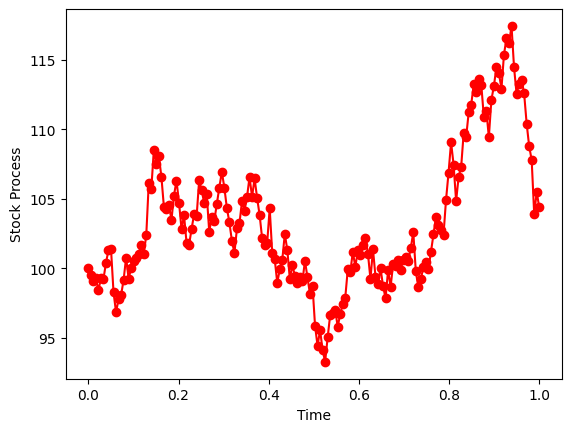

In [14]:
N=180; S=np.zeros([N,1]); S[0]=100
vol=0.2; r=0.02; T=1; dt=T/N
t=np.linspace(0, T, N)
z=np.random.normal(0, 1, N)

for i in range(N-1):
    S[i+1,0]=S[i,0]*np.exp((r-0.5*vol**2)*dt+vol*z[i]*np.sqrt(dt))
plt.plot(t, S[:,0], 'ro-')
plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.show()

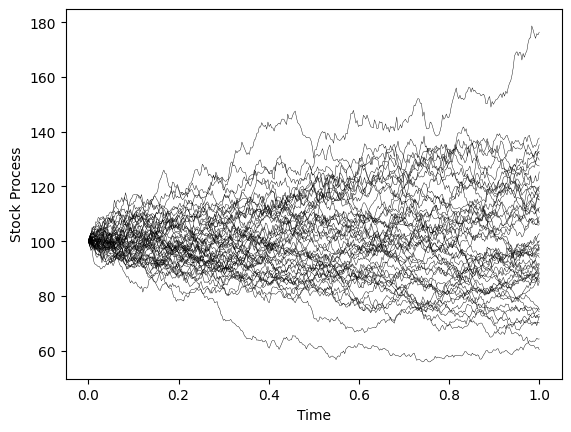

In [15]:
N=365; S=np.zeros([N,1]); S[0]=100
vol=0.2; r=0.02; T=1; dt=T/N
t=np.linspace(0, T, N)
plt.xlabel('Time')
plt.ylabel('Stock Process')
for k in range(0,50):
    z=np.random.normal(0, 1, N)
    for i in range(N-1):
        S[i+1,0]=S[i,0]*np.exp((r-0.5*vol**2)*dt+vol*z[i]*np.sqrt(dt))
    plt.plot(t[:], S[:], 'k-', linewidth=0.3)
plt.show()

## MC를 이용한 ELS 가격결정

### 기초자산이 1개인 ELS

#### ① KOSPI200 기초자산 ELS

In [16]:
import numpy as np
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [17]:
n=10000    # 시뮬레이션 횟수
r=0.0250    # 이자율, 3년 국고채 금리
vol=0.2163 # 변동성
n0=date.toordinal(date(2025,3,19))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,9,16))  # 1차 조기 상환일
n2=date.toordinal(date(2026,3,16))  # 2차 조기 상환일
n3=date.toordinal(date(2026,9,16))  # 3차 조기 상환일
n4=date.toordinal(date(2027,3,16))  # 4차 조기 상환일
n5=date.toordinal(date(2027,9,10))  # 5차 조기 상환일
n6=date.toordinal(date(2028,3,15))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.70])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
kib=0.6*S[0]; dummy=0.183  # 낙인 배리어, 더미 이자율

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.0305, 0.061, 0.0915, 0.122, 0.1525, 0.183])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

In [18]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [19]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9934.566414611763


In [20]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6268, 발생빈도 : 62.68 %
2차 : 1487, 발생빈도 : 14.87 %
3차 : 665, 발생빈도 : 6.65 %
4차 : 404, 발생빈도 : 4.04 %
5차 : 269, 발생빈도 : 2.69 %
6차 : 192, 발생빈도 : 1.92 %
만기상환 발생횟수 : 42, 발생빈도 : 0.42 %
만기손실 발생횟수 : 673, 발생빈도 : 6.73 %


/tmp/ipython-input-20-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [29]:
lamb = 1.5
mu = -0.055
delta = 0.13

In [30]:
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

In [31]:
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [32]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    sn1 = npr.standard_normal(tot_date)
    poi = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-rj-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j] + (np.exp(mu + delta * sn1[j]) - 1) * poi[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9813.653961609554


In [33]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6218, 발생빈도 : 62.18 %
2차 : 1360, 발생빈도 : 13.60 %
3차 : 645, 발생빈도 : 6.45 %
4차 : 422, 발생빈도 : 4.22 %
5차 : 283, 발생빈도 : 2.83 %
6차 : 220, 발생빈도 : 2.20 %
만기상환 발생횟수 : 16, 발생빈도 : 0.16 %
만기손실 발생횟수 : 836, 발생빈도 : 8.36 %


/tmp/ipython-input-33-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### 개별주식이 기초자산인 ELS 평가(Palantir Technologies Inc. Class A)

In [34]:
import numpy as np
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [35]:
n=10000    # 시뮬레이션 횟수
r=0.025    # 이자율, 3년 국고채 금리
vol=0.699  # 변동성
n0=date.toordinal(date(2025,2,14))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,8,12))  # 1차 조기 상환일
n2=date.toordinal(date(2026,2,11))  # 2차 조기 상환일
n3=date.toordinal(date(2026,8,12))  # 3차 조기 상환일
n4=date.toordinal(date(2027,2,10))  # 4차 조기 상환일
n5=date.toordinal(date(2027,8,11))  # 5차 조기 상환일
n6=date.toordinal(date(2028,2,10))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.80, 0.80, 0.80, 0.75, 0.70, 0.65])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
kib=0.2*S[0]; dummy=0.30  # 낙인 배리어, 더미 이자율

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

In [36]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [37]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           St = (S[-3]+S[-2]+S[-1])/3
           payoff[-1]=facevalue*(St/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8926.011866809178


In [38]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5849, 발생빈도 : 58.49 %
2차 : 900, 발생빈도 : 9.00 %
3차 : 345, 발생빈도 : 3.45 %
4차 : 268, 발생빈도 : 2.68 %
5차 : 193, 발생빈도 : 1.93 %
6차 : 148, 발생빈도 : 1.48 %
만기상환 발생횟수 : 414, 발생빈도 : 4.14 %
만기손실 발생횟수 : 1883, 발생빈도 : 18.83 %


/tmp/ipython-input-38-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [39]:
lamb = 1.2
mu = -0.175
delta = 0.1

In [40]:
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

In [41]:
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [42]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    sn1 = npr.standard_normal(tot_date)
    poi = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-rj-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j] + (np.exp(mu + delta * sn1[j]) - 1) * poi[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8984.616371837346


In [43]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6046, 발생빈도 : 60.46 %
2차 : 845, 발생빈도 : 8.45 %
3차 : 381, 발생빈도 : 3.81 %
4차 : 258, 발생빈도 : 2.58 %
5차 : 190, 발생빈도 : 1.90 %
6차 : 137, 발생빈도 : 1.37 %
만기상환 발생횟수 : 351, 발생빈도 : 3.51 %
만기손실 발생횟수 : 1792, 발생빈도 : 17.92 %


/tmp/ipython-input-43-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### 개별주식이 기초자산인 ELS 평가 Tesla Inc.(UW)

In [45]:
n=10000    # 시뮬레이션 횟수
r=0.025    # 이자율, 3년 국고채 금리
vol=0.7546  # 변동성
n0=date.toordinal(date(2025,3,28))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,9,24))  # 1차 조기 상환일
n2=date.toordinal(date(2026,3,25))  # 2차 조기 상환일
n3=date.toordinal(date(2026,9,22))  # 3차 조기 상환일
n4=date.toordinal(date(2027,3,24))  # 4차 조기 상환일
n5=date.toordinal(date(2027,9,24))  # 5차 조기 상환일
n6=date.toordinal(date(2028,3,24))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.80, 0.80, 0.80, 0.75, 0.70, 0.65])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
kib=0.25*S[0]; dummy=0.453  # 낙인 배리어, 더미 이자율

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.075, 0.15, 0.225, 0.30, 0.375, 0.453])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

In [46]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [47]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           St = (S[-3]+S[-2]+S[-1])/3
           payoff[-1]=facevalue*(St/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8863.443826158295


In [48]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5743, 발생빈도 : 57.43 %
2차 : 865, 발생빈도 : 8.65 %
3차 : 381, 발생빈도 : 3.81 %
4차 : 268, 발생빈도 : 2.68 %
5차 : 195, 발생빈도 : 1.95 %
6차 : 145, 발생빈도 : 1.45 %
만기상환 발생횟수 : 134, 발생빈도 : 1.34 %
만기손실 발생횟수 : 2269, 발생빈도 : 22.69 %


/tmp/ipython-input-48-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [49]:
lamb = 1.2
mu = -0.19
delta = 0.1

In [50]:
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

In [51]:
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [52]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    sn1 = npr.standard_normal(tot_date)
    poi = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-rj-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j] + (np.exp(mu + delta * sn1[j]) - 1) * poi[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8774.542577927574


In [53]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5725, 발생빈도 : 57.25 %
2차 : 856, 발생빈도 : 8.56 %
3차 : 406, 발생빈도 : 4.06 %
4차 : 244, 발생빈도 : 2.44 %
5차 : 197, 발생빈도 : 1.97 %
6차 : 135, 발생빈도 : 1.35 %
만기상환 발생횟수 : 94, 발생빈도 : 0.94 %
만기손실 발생횟수 : 2343, 발생빈도 : 23.43 %


/tmp/ipython-input-53-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


### 기초자산이 2개인 ELS

#### 2개의 기초자산이 상관계수를 갖는 주가 경로 생성

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import correlate
plt.close()

In [ ]:
x_vol=0.25; y_vol=0.30
r=0.035
rho=0.3
N=100; T=1
S1=np.zeros((N+1, 1))
S2=np.zeros((N+1, 1))
S1[0]=100; S2[0]=100
dt=T/N; t=np.linspace(0, T, N+1)
correlation=np.array([[1, rho], [rho, 1]])
cholesky=np.linalg.cholesky(correlation)
z0=np.random.normal(0, 1, size=[N, 2])
np.random.seed(56)
z0=np.transpose(z0)
z=np.matmul(cholesky, z0)
Worst_performer=np.zeros((N+1, 1))

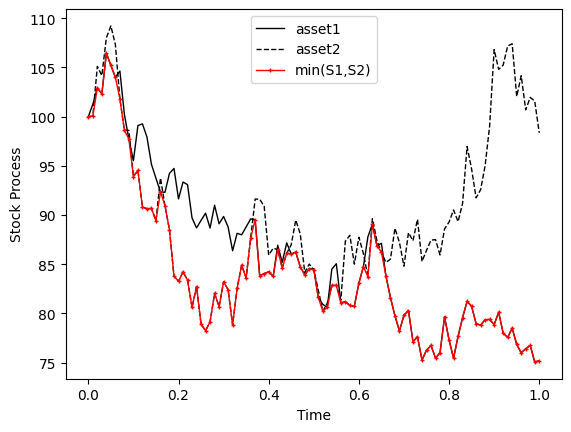

In [ ]:
for i in range(N):
    S1[i+1]=S1[i]*np.exp((r-0.5*x_vol**2)*dt+x_vol*z[0,i]*np.sqrt(dt))
    S2[i+1]=S2[i]*np.exp((r-0.5*y_vol**2)*dt+y_vol*z[1,i]*np.sqrt(dt))
    Worst_performer[i]=min(S1[i,0], S2[i,0])
    Worst_performer[-1]=min(S1[-1,0], S2[-1,0])

plt.plot(t, S1[:], 'k-', label='asset1', linewidth=1, markersize=3.5)
plt.plot(t, S2[:], 'k--', label='asset2', linewidth=1, markersize=3.5)
plt.plot(t, Worst_performer[:], 'r+-', label='min(S1,S2)', linewidth=1, markersize=3.5)
plt.legend()
# plt.xlim(0, 1.0)
# plt.ylim(70, 130)
plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.legend(prop={'size':10})
plt.show()

#### 2개의 기초자산 ELS 가격 계산

#### 지수로 구성하는 경우(GBM)

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025  # 시뮬레이션 횟수, 무위험이자율
x_vol=0.2182; y_vol=0.3063  # 두 지수의 연간 변동성
rho=0.2244; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
n0=date.toordinal(date(2025, 3, 20))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 9, 16))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 3, 17))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 9, 15))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 3, 16))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 9, 10))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 3, 15))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
coupon_rate=np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])  # 조기 상환시 쿠폰 이자율
oneyear=365; tot_date=n6-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
strike_price=np.array([0.90, 0.85, 0.85, 0.80, 0.80, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
kib=0.45; dummy=0.21  # 낙인 배리어, 더미 이자율
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9753.658906849138


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5315, 발생빈도 : 53.15 %
2차 : 1431, 발생빈도 : 14.31 %
3차 : 487, 발생빈도 : 4.87 %
4차 : 439, 발생빈도 : 4.39 %
5차 : 235, 발생빈도 : 2.35 %
6차 : 229, 발생빈도 : 2.29 %
만기상환 발생횟수 : 782, 발생빈도 : 7.82 %
만기손실 발생횟수 : 1082, 발생빈도 : 10.82 %


<ipython-input-38-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Jump Diffusion Model

In [ ]:
lamb = 1.4
mu1 = -0.05
mu2 = -0.08
delta = 0.1

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9531.078654017829


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5014, 발생빈도 : 50.14 %
2차 : 1463, 발생빈도 : 14.63 %
3차 : 501, 발생빈도 : 5.01 %
4차 : 445, 발생빈도 : 4.45 %
5차 : 253, 발생빈도 : 2.53 %
6차 : 271, 발생빈도 : 2.71 %
만기상환 발생횟수 : 645, 발생빈도 : 6.45 %
만기손실 발생횟수 : 1408, 발생빈도 : 14.08 %


<ipython-input-43-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### 기초자산이 두 개(지수+종목)인 ELS 평가

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025  # 시뮬레이션 횟수, 무위험이자율
x_vol=0.2163; y_vol=0.316  # 지수, 종목의 연간 변동성
rho=0.8143; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
n0=date.toordinal(date(2025, 3, 19))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 9, 16))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 3, 16))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 9, 16))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 3, 16))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 9, 10))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 3, 15))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
coupon_rate=np.array([0.037, 0.074, 0.111, 0.148, 0.185, 0.222])  # 조기 상환시 쿠폰 이자율
oneyear=365; tot_date=n6-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
strike_price=np.array([0.90, 0.90, 0.85, 0.85, 0.80, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
kib=0.50; dummy=0.222  # 낙인 배리어, 더미 이자율
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9642.608093198201


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6197, 발생빈도 : 61.97 %
2차 : 911, 발생빈도 : 9.11 %
3차 : 633, 발생빈도 : 6.33 %
4차 : 278, 발생빈도 : 2.78 %
5차 : 243, 발생빈도 : 2.43 %
6차 : 238, 발생빈도 : 2.38 %
만기상환 발생횟수 : 253, 발생빈도 : 2.53 %
만기손실 발생횟수 : 1247, 발생빈도 : 12.47 %


<ipython-input-67-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 1.4
mu1 = -0.05
mu2 = -0.08
delta = 0.12

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9434.806183108201


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5642, 발생빈도 : 56.42 %
2차 : 938, 발생빈도 : 9.38 %
3차 : 688, 발생빈도 : 6.88 %
4차 : 299, 발생빈도 : 2.99 %
5차 : 317, 발생빈도 : 3.17 %
6차 : 267, 발생빈도 : 2.67 %
만기상환 발생횟수 : 256, 발생빈도 : 2.56 %
만기손실 발생횟수 : 1593, 발생빈도 : 15.93 %


<ipython-input-72-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### 기초자산이 두 개(개별종목)인 ELS 평가

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025  # 시뮬레이션 횟수, 무위험이자율
x_vol=0.7045; y_vol=0.6854  # 두 종목의 연간 변동성
rho=0.3246; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
n0=date.toordinal(date(2025, 2, 27))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 8, 22))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 2, 24))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 8, 24))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 2, 22))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 8, 24))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 2, 18))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
coupon_rate=np.array([0.0906, 0.1812, 0.2718, 0.3624, 0.453, 0.5436])  # 조기 상환시 쿠폰 이자율
strike_price=np.array([0.90, 0.90, 0.85, 0.80, 0.75, 0.65])  # 조기 행사가격
kib=0.35; dummy=0.5436  # 낙인 배리어, 더미 이자율
oneyear=365; tot_date=n6-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
repay_n=len(strike_price) # 조기상환 횟수
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           WPL=(WP[-1]+WP[-2]+WP[-3])/3
           payoff[-1]=facevalue*WPL
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

13879.246657603042


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6032, 발생빈도 : 60.32 %
2차 : 1629, 발생빈도 : 16.29 %
3차 : 995, 발생빈도 : 9.95 %
4차 : 698, 발생빈도 : 6.98 %
5차 : 516, 발생빈도 : 5.16 %
6차 : 493, 발생빈도 : 4.93 %
만기상환 발생횟수 : 115, 발생빈도 : 1.15 %
만기손실 발생횟수 : 9522, 발생빈도 : 95.22 %


<ipython-input-29-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 1.2
mu1 = -0.17
mu2 = -0.15
delta = 0.1

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

6954.152472228684


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 3112, 발생빈도 : 31.12 %
2차 : 812, 발생빈도 : 8.12 %
3차 : 507, 발생빈도 : 5.07 %
4차 : 318, 발생빈도 : 3.18 %
5차 : 244, 발생빈도 : 2.44 %
6차 : 257, 발생빈도 : 2.57 %
만기상환 발생횟수 : 43, 발생빈도 : 0.43 %
만기손실 발생횟수 : 4707, 발생빈도 : 47.07 %


<ipython-input-34-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


### 기초자산이 3개인 ELS

#### 3개의 기초자산이 상관계수를 갖는 주가 경로 생성

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import correlate

In [ ]:
x_vol=0.2662; y_vol=0.2105; z_vol=0.2111
r=0.0165
rho_xy=0.279; rho_xz=0.2895; rho_yz=0.5256
N=80; T=1; dt=T/N
S1=np.zeros((N+1, 1))
S2=np.zeros((N+1, 1))
S3=np.zeros((N+1, 1))
S1[0]=100; S2[0]=100; S3[0]=100
t=np.linspace(0, T, N+1)
correlation=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
cholesky=np.linalg.cholesky(correlation)
z0=np.random.normal(0, 1, size=[N, 3])
np.random.seed(42)
z0=np.transpose(z0)
z=np.matmul(cholesky, z0)
Worst_performer=np.zeros((N+1, 1))

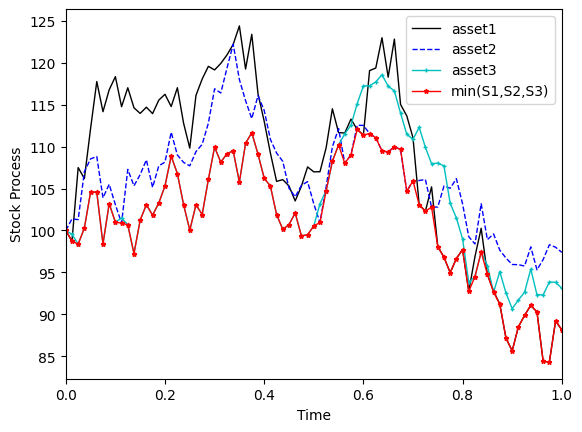

In [ ]:
plt.xlim(0, 1)
# plt.ylim(60, 170)

for i in range(N):
    S1[i+1]=S1[i]*np.exp((r-0.5*x_vol**2)*dt+x_vol*z[0,i]*np.sqrt(dt))
    S2[i+1]=S2[i]*np.exp((r-0.5*y_vol**2)*dt+y_vol*z[1,i]*np.sqrt(dt))
    S3[i+1]=S3[i]*np.exp((r-0.5*z_vol**2)*dt+z_vol*z[2,i]*np.sqrt(dt))
    Worst_performer[i]=min(S1[i,0], S2[i,0], S3[i,0])
    Worst_performer[-1]=min(S1[-1,0], S2[-1,0], S2[-1,0])

plt.plot(t, S1[:], 'k-', label='asset1', linewidth=1, markersize=3.5)
plt.plot(t, S2[:], 'b--', label='asset2', linewidth=1, markersize=3.5)
plt.plot(t, S3[:], 'c+-', label='asset3', linewidth=1, markersize=3.5)
plt.plot(t, Worst_performer[:], 'r*-', label='min(S1,S2,S3)', linewidth=1, markersize=3.5)

plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.legend(prop={'size':10})
plt.show()

#### 3개의 기초자산 ELS 가격 계산

#####Case 1(지수형)

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025
x_vol=0.2182; y_vol=0.3063; z_vol=0.2239
rho_xy=0.2244; rho_xz=0.2546; rho_yz=0.0441 # 상관계수
n0=date.toordinal(date(2025, 3, 21))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 9, 19))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 3, 19))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 9, 18))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 3, 19))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 9, 21))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 3, 21))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.85, 0.85, 0.80, 0.80, 0.75, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.0375, 0.075, 0.1125, 0.15, 0.1875, 0.225])  # 조기 상환시 쿠폰 이자율
kib=0.45; dummy=0.225  # 낙인 배리어, 더미 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9867.025942102597


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6674, 발생빈도 : 66.74 %
2차 : 766, 발생빈도 : 7.66 %
3차 : 542, 발생빈도 : 5.42 %
4차 : 243, 발생빈도 : 2.43 %
5차 : 264, 발생빈도 : 2.64 %
6차 : 129, 발생빈도 : 1.29 %
만기상환 발생횟수 : 508, 발생빈도 : 5.08 %
만기손실 발생횟수 : 874, 발생빈도 : 8.74 %


<ipython-input-12-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 1.6
mu1 = -0.055
mu2 = -0.075
mu3 = -0.055
delta = 0.13

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)
rj3 = lamb * (math.exp(mu3 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    sn13 = npr.standard_normal(tot_date)
    poi3 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
        S3[j+1]=S3[j]*np.exp((r-rj3-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j]+(np.exp(mu3 + delta * sn13[j]) - 1) * poi3[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9531.936640714328


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6078, 발생빈도 : 60.78 %
2차 : 892, 발생빈도 : 8.92 %
3차 : 585, 발생빈도 : 5.85 %
4차 : 263, 발생빈도 : 2.63 %
5차 : 286, 발생빈도 : 2.86 %
6차 : 138, 발생빈도 : 1.38 %
만기상환 발생횟수 : 397, 발생빈도 : 3.97 %
만기손실 발생횟수 : 1361, 발생빈도 : 13.61 %


<ipython-input-17-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


####Case 2(지수+종목)

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025
x_vol=0.241; y_vol=0.2212; z_vol=0.2071
rho_xy=0.3825; rho_xz=0.2595; rho_yz=0.2121  # 상관계수
n0=date.toordinal(date(2025, 2, 25))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 8, 25))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 2, 25))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 8, 25))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 2, 25))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 8, 25))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 2, 25))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.90, 0.90, 0.85, 0.80, 0.75, 0.70])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.044, 0.088, 0.132, 0.176, 0.22, 0.264])  # 조기 상환시 쿠폰 이자율
kib=0.45; dummy=0.264  # 낙인 배리어, 더미 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

10393.1839078339


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6259, 발생빈도 : 62.59 %
2차 : 920, 발생빈도 : 9.20 %
3차 : 659, 발생빈도 : 6.59 %
4차 : 474, 발생빈도 : 4.74 %
5차 : 357, 발생빈도 : 3.57 %
6차 : 267, 발생빈도 : 2.67 %
만기상환 발생횟수 : 730, 발생빈도 : 7.30 %
만기손실 발생횟수 : 334, 발생빈도 : 3.34 %


<ipython-input-22-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 1.8
mu1 = -0.05
mu2 = -0.055
mu3 = -0.08
delta = 0.20

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)
rj3 = lamb * (math.exp(mu3 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    sn13 = npr.standard_normal(tot_date)
    poi3 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
        S3[j+1]=S3[j]*np.exp((r-rj3-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j]+(np.exp(mu3 + delta * sn13[j]) - 1) * poi3[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9580.400082878888


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5099, 발생빈도 : 50.99 %
2차 : 936, 발생빈도 : 9.36 %
3차 : 719, 발생빈도 : 7.19 %
4차 : 517, 발생빈도 : 5.17 %
5차 : 400, 발생빈도 : 4.00 %
6차 : 305, 발생빈도 : 3.05 %
만기상환 발생횟수 : 476, 발생빈도 : 4.76 %
만기손실 발생횟수 : 1548, 발생빈도 : 15.48 %


<ipython-input-35-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Case 3(지수+No Knock-in)

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025
x_vol=0.2061; y_vol=0.2404; z_vol=0.2186
rho_xy=0.2787; rho_xz=0.3707; rho_yz=0.3572  # 상관계수
n0=date.toordinal(date(2025, 3, 14))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 9, 12))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 3, 13))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 9, 14))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 3, 12))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 9, 13))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 3, 14))  # 만기 평가일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.85, 0.85, 0.80, 0.80, 0.75, 0.60])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.033, 0.066, 0.099, 0.132, 0.165, 0.198])  # 조기 상환시 쿠폰 이자율
kib=0.0; dummy=0.198  # 낙인 배리어, 더미 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if WP[-1] >= 0.6:  # 기준종목이 60% 이상 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 기준종목이 60% 미만 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9945.446180458506


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 7375, 발생빈도 : 73.75 %
2차 : 677, 발생빈도 : 6.77 %
3차 : 535, 발생빈도 : 5.35 %
4차 : 208, 발생빈도 : 2.08 %
5차 : 188, 발생빈도 : 1.88 %
6차 : 405, 발생빈도 : 4.05 %
만기상환 발생횟수 : 0, 발생빈도 : 0.00 %
만기손실 발생횟수 : 612, 발생빈도 : 6.12 %


<ipython-input-25-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 1.6
mu1 = -0.05
mu2 = -0.06
mu3 = -0.055
delta = 0.15

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)
rj3 = lamb * (math.exp(mu3 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    sn13 = npr.standard_normal(tot_date)
    poi3 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
        S3[j+1]=S3[j]*np.exp((r-rj3-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j]+(np.exp(mu3 + delta * sn13[j]) - 1) * poi3[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if WP[-1] >= 0.65:  # 기준종목이 65% 이상 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 기준종목이 65% 미만 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9608.434204930318


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6590, 발생빈도 : 65.90 %
2차 : 748, 발생빈도 : 7.48 %
3차 : 542, 발생빈도 : 5.42 %
4차 : 258, 발생빈도 : 2.58 %
5차 : 239, 발생빈도 : 2.39 %
6차 : 488, 발생빈도 : 4.88 %
만기상환 발생횟수 : 0, 발생빈도 : 0.00 %
만기손실 발생횟수 : 1135, 발생빈도 : 11.35 %


<ipython-input-36-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Case 4(종목)

##### GBM

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date
import math
import numpy.random as npr
from pylab import plt, mpl

In [ ]:
n=10000; r=0.025
x_vol=0.6203; y_vol=0.7143; z_vol=0.6428
rho_xy=0.339; rho_xz=0.5981; rho_yz=0.4318  # 상관계수
n0=date.toordinal(date(2025, 3, 13))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025, 9, 10))  # 1차 조기 상환일
n2=date.toordinal(date(2026, 3, 10))  # 2차 조기 상환일
n3=date.toordinal(date(2026, 9, 9))  # 3차 조기 상환일
n4=date.toordinal(date(2027, 3, 10))  # 4차 조기 상환일
n5=date.toordinal(date(2027, 9, 8))  # 5차 조기 상환일
n6=date.toordinal(date(2028, 3, 8))  # 만기 평가일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.85, 0.85, 0.80, 0.75, 0.70, 0.65])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.11, 0.22, 0.33, 0.44, 0.55, 0.66])  # 조기 상환시 쿠폰 이자율
kib=0.35; dummy=0.66  # 낙인 배리어, 더미 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

7671.796910652914


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 3579, 발생빈도 : 35.79 %
2차 : 822, 발생빈도 : 8.22 %
3차 : 535, 발생빈도 : 5.35 %
4차 : 355, 발생빈도 : 3.55 %
5차 : 270, 발생빈도 : 2.70 %
6차 : 198, 발생빈도 : 1.98 %
만기상환 발생횟수 : 62, 발생빈도 : 0.62 %
만기손실 발생횟수 : 4179, 발생빈도 : 41.79 %


<ipython-input-42-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


##### Jump Diffusion Model

In [ ]:
lamb = 4.2
mu1 = -0.155
mu2 = -0.1785
mu3 = -0.16
delta = 0.42

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)
rj3 = lamb * (math.exp(mu3 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    sn13 = npr.standard_normal(tot_date)
    poi3 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
        S3[j+1]=S3[j]*np.exp((r-rj3-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j]+(np.exp(mu3 + delta * sn13[j]) - 1) * poi3[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

6920.211641836089


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 3001, 발생빈도 : 30.01 %
2차 : 839, 발생빈도 : 8.39 %
3차 : 545, 발생빈도 : 5.45 %
4차 : 404, 발생빈도 : 4.04 %
5차 : 273, 발생빈도 : 2.73 %
6차 : 243, 발생빈도 : 2.43 %
만기상환 발생횟수 : 1, 발생빈도 : 0.01 %
만기손실 발생횟수 : 4694, 발생빈도 : 46.94 %


<ipython-input-88-0e48ea33c432>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")
